# Sentiment analysis

The goal for this assignment is to classify feelings in a text corpus. Each row has a sentence with corresponding emotion.

In [1]:
import pandas as pd
import string
import re
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
import os 
import datetime
import numpy as np

import timeit
from keras.callbacks import ModelCheckpoint


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SimpleRNN, GRU

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


import tensorflow as tf

from sklearn.model_selection import train_test_split


import ssl 


try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context



nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

2024-01-29 19:40:14.244070: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joeloscarsson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/joeloscarsson/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/joeloscarsson/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
STOPWORDS_DEFAULT = nltk.corpus.stopwords.words('english')
LEMMATIZER = nltk.stem.WordNetLemmatizer()

FILE = "./data/emotions.csv"
LOGS_PATH = ("./logs")

NUM_CLASSES = 6

In [3]:
def get_separator():
    """ Returns a separator """
    print("======================================================")
    

def get_file():
    """ Get the file and return it as a pandas dataframe"""
    data = pd.read_csv(FILE)
    pd.set_option('display.max_colwidth', 200) # too be able to see more of the text
    return data

In [4]:
get_file()

,text,label
0,i feel so pissed off over an old friend and some friends,anger
1,ive found it has made a huge difference especially on the finger with my ring and the my skin feels so much softer and less irritated,anger
2,i also feel it is unfortunate that nearly all the readers of going to meet the man will be african americans unlike myself,sadness
3,i feel petty a href http clairee,anger
4,i used to believe that a feeling like fear was to be ignored or suppressed right away more on this in a moment,sadness
...,...,...
19995,i was i might be buying stuff from there but i feel the clothes are too casual,joy
19996,i like sonam deepika and genelia who i feel are very talented and beautiful,joy
19997,i feel pathetic that i can hardly go a whole day not talking to him,sadness
19998,id have spent more time with her on reading i feel a bit guilty about that,sadness


# Exploration of data


In [5]:
get_file().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20000 non-null  object
 1   label   20000 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


In [6]:
get_file()['label'].unique()

array(['anger', 'sadness', 'joy', 'love', 'fear', 'surprise'],
      dtype=object)

Label anger has 2709 rows
Label sadness has 5797 rows
Label joy has 6761 rows
Label love has 1641 rows
Label fear has 2373 rows
Label surprise has 719 rows


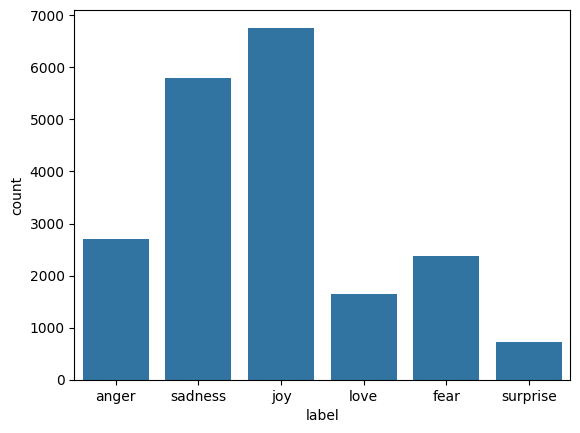

In [7]:
plot = get_file()

sns.countplot(plot, x='label');


print(f'Label anger has {len(get_file()[get_file()["label"] == "anger"])} rows')
print(f'Label sadness has {len(get_file()[get_file()["label"] == "sadness"])} rows')
print(f'Label joy has {len(get_file()[get_file()["label"] == "joy"])} rows')
print(f'Label love has {len(get_file()[get_file()["label"] == "love"])} rows')
print(f'Label fear has {len(get_file()[get_file()["label"] == "fear"])} rows')
print(f'Label surprise has {len(get_file()[get_file()["label"] == "surprise"])} rows')

We want to separate these 6 emotions into 3 categories because some of the feelings are similar. These categories are positive, negative and neutral. We want to group the emotions with corresponding category. 
This means we can re-label to new categories:

* Negative
    - 'anger'
    - 'sadness'
    - 'fear'

* Neutral
    - 'surprise'

* Positive
    - 'joy'
    - 'love'

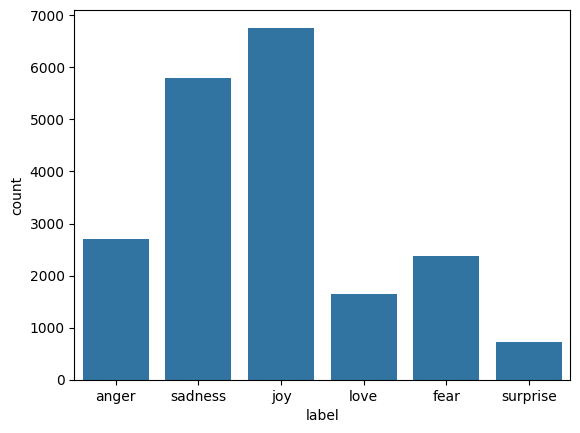

In [8]:
df =  get_file()


# Commented out the label map to use the original labels instead

# label_map = {
#     'anger': 'Negative',
#     'sadness': 'Negative',
#     'fear': 'Negative',
#     'surprise': 'Neutral',
#     'joy': 'Positive',
#     'love': 'Positive',
# }

# df['label'] = df['label'].map(label_map) # changes the names of the labels to suit the 3 classes

sns.countplot(df, x='label');

So the dataset is not balanced. So this will be an issue that might need to be investigated further if the models tends to be biased towards negative feelings. It might also introduce some challenges with the evaluation since it is not even. 

# Tokenization

In [9]:
def get_clean_text(df):
    """"
    Takes in a df column "text" and:
    - converts everything to lowercase
    - removes punctuation
    - removes extra whitespaces
    - adjustes words or removes them
    
    Returns: cleaned df
    
    """

    full_word_mapping = {
        r'\bid\b': 'i would',
        r'\bim\b': 'i am',
        r'\bive\b': 'i have',
        r'\bill\b': 'i will',
        r'\bdont\b': 'do not',
        r'\bwoulde\b': 'would have',
        r'\bfeeling\b': 'feel',
        r'\bfelt\b': 'feel',
        r'\bi havent\b': 'i have not',
        r'\bamportant\b': 'important',
    }

    words_to_remove = {
        'href',
        'ti',
        'wi',
        'hi',
        'sti',
        'ames',
        'le',
        'gi',
        'si',
        'http',
        'href',
    }

    df['text'] = df['text'].apply(lambda x: ' '.join(word for word in x.split() if word not in words_to_remove)) # applies and removes the words in the set that are not needed because they are shit

    df['text'] = df['text'].replace(full_word_mapping, regex=True) # replaces the words to its full form

    df['text'] = df['text'].str.lower() # makes everything lowercase

    df['text'] = df['text'].apply(lambda x: ' '.join(x.split())) # removes the extra whitespaces

    df['text'] = df['text'].str.replace(f'[{string.punctuation}]', '', regex=True) # removes the punctuation
    

    return df

get_clean_text(df)

,text,label
0,i feel so pissed off over an old friend and some friends,anger
1,i have found it has made a huge difference especially on the finger with my ring and the my skin feels so much softer and less irritated,anger
2,i also feel it is unfortunate that nearly all the readers of going to meet the man will be african americans unlike myself,sadness
3,i feel petty a clairee,anger
4,i used to believe that a feel like fear was to be ignored or suppressed right away more on this in a moment,sadness
...,...,...
19995,i was i might be buying stuff from there but i feel the clothes are too casual,joy
19996,i like sonam deepika and genelia who i feel are very talented and beautiful,joy
19997,i feel pathetic that i can hardly go a whole day not talking to him,sadness
19998,i would have spent more time with her on reading i feel a bit guilty about that,sadness


In [10]:
def tokenize(df):
    """"
    Takes in a df column

    Returns: column with the text tokenized and each row is corresponding to correct index
    
    """

    df['tokenized_text'] = df['text'].apply(nltk.word_tokenize) # tokenizes the text

    # tokenized_text = df['tokenized_text'].explode().reset_index() # transform each element and replicate index values to match each row. 


    # display(tokenized_text['index'].unique()) # this is to see that the index matches the original df rows (20K)

    return df

tokenize(df)

,text,label,tokenized_text
0,i feel so pissed off over an old friend and some friends,anger,"[i, feel, so, pissed, off, over, an, old, friend, and, some, friends]"
1,i have found it has made a huge difference especially on the finger with my ring and the my skin feels so much softer and less irritated,anger,"[i, have, found, it, has, made, a, huge, difference, especially, on, the, finger, with, my, ring, and, the, my, skin, feels, so, much, softer, and, less, irritated]"
2,i also feel it is unfortunate that nearly all the readers of going to meet the man will be african americans unlike myself,sadness,"[i, also, feel, it, is, unfortunate, that, nearly, all, the, readers, of, going, to, meet, the, man, will, be, african, americans, unlike, myself]"
3,i feel petty a clairee,anger,"[i, feel, petty, a, clairee]"
4,i used to believe that a feel like fear was to be ignored or suppressed right away more on this in a moment,sadness,"[i, used, to, believe, that, a, feel, like, fear, was, to, be, ignored, or, suppressed, right, away, more, on, this, in, a, moment]"
...,...,...,...
19995,i was i might be buying stuff from there but i feel the clothes are too casual,joy,"[i, was, i, might, be, buying, stuff, from, there, but, i, feel, the, clothes, are, too, casual]"
19996,i like sonam deepika and genelia who i feel are very talented and beautiful,joy,"[i, like, sonam, deepika, and, genelia, who, i, feel, are, very, talented, and, beautiful]"
19997,i feel pathetic that i can hardly go a whole day not talking to him,sadness,"[i, feel, pathetic, that, i, can, hardly, go, a, whole, day, not, talking, to, him]"
19998,i would have spent more time with her on reading i feel a bit guilty about that,sadness,"[i, would, have, spent, more, time, with, her, on, reading, i, feel, a, bit, guilty, about, that]"


# Remove stopwords

In [11]:
def remove_stopwords(df, STOPWORDS_DEFAULT):
    """ Remove stopwords from the tokenized text (df) """

    df['tokenized_text'] = df['tokenized_text'].apply(lambda words: [word for word in words if word not in STOPWORDS_DEFAULT])

    return

remove_stopwords(df, STOPWORDS_DEFAULT)

In [12]:
df

,text,label,tokenized_text
0,i feel so pissed off over an old friend and some friends,anger,"[feel, pissed, old, friend, friends]"
1,i have found it has made a huge difference especially on the finger with my ring and the my skin feels so much softer and less irritated,anger,"[found, made, huge, difference, especially, finger, ring, skin, feels, much, softer, less, irritated]"
2,i also feel it is unfortunate that nearly all the readers of going to meet the man will be african americans unlike myself,sadness,"[also, feel, unfortunate, nearly, readers, going, meet, man, african, americans, unlike]"
3,i feel petty a clairee,anger,"[feel, petty, clairee]"
4,i used to believe that a feel like fear was to be ignored or suppressed right away more on this in a moment,sadness,"[used, believe, feel, like, fear, ignored, suppressed, right, away, moment]"
...,...,...,...
19995,i was i might be buying stuff from there but i feel the clothes are too casual,joy,"[might, buying, stuff, feel, clothes, casual]"
19996,i like sonam deepika and genelia who i feel are very talented and beautiful,joy,"[like, sonam, deepika, genelia, feel, talented, beautiful]"
19997,i feel pathetic that i can hardly go a whole day not talking to him,sadness,"[feel, pathetic, hardly, go, whole, day, talking]"
19998,i would have spent more time with her on reading i feel a bit guilty about that,sadness,"[would, spent, time, reading, feel, bit, guilty]"


# Lemmatization
* Reduce the words to their base form. for instance "running" -> "run"

In [13]:
def lemmatize(df, lemmatizer):
    """ Lemmatize list of words in the tokenized_text column df """

    df['tokenized_text'] = df['tokenized_text'].apply(lambda words: [lemmatizer.lemmatize(word) for word in words])
    
    return df


lemmatize(df, LEMMATIZER)
    

,text,label,tokenized_text
0,i feel so pissed off over an old friend and some friends,anger,"[feel, pissed, old, friend, friend]"
1,i have found it has made a huge difference especially on the finger with my ring and the my skin feels so much softer and less irritated,anger,"[found, made, huge, difference, especially, finger, ring, skin, feel, much, softer, le, irritated]"
2,i also feel it is unfortunate that nearly all the readers of going to meet the man will be african americans unlike myself,sadness,"[also, feel, unfortunate, nearly, reader, going, meet, man, african, american, unlike]"
3,i feel petty a clairee,anger,"[feel, petty, clairee]"
4,i used to believe that a feel like fear was to be ignored or suppressed right away more on this in a moment,sadness,"[used, believe, feel, like, fear, ignored, suppressed, right, away, moment]"
...,...,...,...
19995,i was i might be buying stuff from there but i feel the clothes are too casual,joy,"[might, buying, stuff, feel, clothes, casual]"
19996,i like sonam deepika and genelia who i feel are very talented and beautiful,joy,"[like, sonam, deepika, genelia, feel, talented, beautiful]"
19997,i feel pathetic that i can hardly go a whole day not talking to him,sadness,"[feel, pathetic, hardly, go, whole, day, talking]"
19998,i would have spent more time with her on reading i feel a bit guilty about that,sadness,"[would, spent, time, reading, feel, bit, guilty]"


# Assign a unique number to each unique word

- We need to assign a unique number to each unique word to vectorize it.
- Also i change the labels positive/neutral/negative to numerical numbers

In [14]:
def id_each_unique_word(df):
    """" 
    Mapping each unique word to an id
    
    Returns: 
    - word_to_id (maps the words to an id) 
    - id_to_word (maps the id to a word)
    
    """

    index_each_word = df['tokenized_text'].explode().unique()

    word_to_id = {}
    id_to_word = {}


    for i, token in enumerate(set(index_each_word)):
        word_to_id[token] = i
        id_to_word[i] = token


    display(word_to_id)

    return word_to_id, id_to_word


word_to_id, id_to_word = id_each_unique_word(df)

# Changed here to use the original labels instead of the mapped ones

def change_label_to_int(df):
    """ Change the labels column positive, neutral, negative to ints """

    df['label'] = df['label'].replace({'anger': 0, 'sadness': 1, 'fear': 2, 'surprise': 3, 'joy': 4, 'love': 5})

    return

change_label_to_int(df)

{'princess': 0,
 'hallmark': 1,
 'carroll': 2,
 'apologetic': 3,
 'library': 4,
 'fudge': 5,
 'pile': 6,
 'usage': 7,
 'counter': 8,
 'apothecary': 9,
 'rub': 10,
 'pass': 11,
 'kinison': 12,
 'contact': 13,
 'feeding': 14,
 'october': 15,
 'disregarded': 16,
 'errrr': 17,
 'patel': 18,
 'back': 19,
 'corrected': 20,
 'ballistic': 21,
 'pounded': 22,
 'pander': 23,
 'demand': 24,
 'discontent': 25,
 'hiked': 26,
 'quaker': 27,
 'itsy': 28,
 'interpretation': 29,
 'muay': 30,
 'tingle': 31,
 'protects': 32,
 'freshman': 33,
 'l': 34,
 'absorption': 35,
 'whizz': 36,
 'sensitivity': 37,
 'admits': 38,
 'kg': 39,
 'unfashionable': 40,
 'customized': 41,
 'bodega': 42,
 'reneging': 43,
 'budget': 44,
 'condescend': 45,
 'cunt': 46,
 'parisian': 47,
 'seasonal': 48,
 'proported': 49,
 'soulation': 50,
 'heureulsurok': 51,
 'thats': 52,
 'forefinger': 53,
 'katy': 54,
 'isight': 55,
 'funded': 56,
 'terrifyingly': 57,
 'terrible': 58,
 'nicole': 59,
 'cancel': 60,
 'biking': 61,
 'flexy': 62

# Word Embedding

In [15]:
def text_to_sequence(word_to_id):
    """ 
    Convert sentences to sequences from word_of_id mapping
      
    Returns: sequence of ints where each sequence corresponds to a sentence
      
    """

    sequences = []


    for index, sentence in enumerate(df['tokenized_text']):

        # for each word in the sentence get the corresponding id from mapping and put in list, if not found return None
        seq = [word_to_id.get(word, None) for word in sentence]
        sequences.append(seq)

        if index < 5: # 5 examples to make sure its correct converted
            print(f"Sentence {index+1}: {sentence}")
            get_separator
            print(f"Converted to Sequence: {index+1}: {seq}")
            get_separator()


    return sequences


sequences = text_to_sequence(word_to_id)


print(f'Amount of text sequences (rows): {len(sequences)}') 


Sentence 1: ['feel', 'pissed', 'old', 'friend', 'friend']
Converted to Sequence: 1: [3493, 681, 9383, 13184, 13184]
Sentence 2: ['found', 'made', 'huge', 'difference', 'especially', 'finger', 'ring', 'skin', 'feel', 'much', 'softer', 'le', 'irritated']
Converted to Sequence: 2: [8987, 3772, 12138, 10553, 10089, 11808, 3861, 12680, 3493, 7248, 12001, 3216, 3709]
Sentence 3: ['also', 'feel', 'unfortunate', 'nearly', 'reader', 'going', 'meet', 'man', 'african', 'american', 'unlike']
Converted to Sequence: 3: [10750, 3493, 4296, 10563, 10683, 9147, 5067, 3713, 8153, 13563, 2923]
Sentence 4: ['feel', 'petty', 'clairee']
Converted to Sequence: 4: [3493, 1195, 4900]
Sentence 5: ['used', 'believe', 'feel', 'like', 'fear', 'ignored', 'suppressed', 'right', 'away', 'moment']
Converted to Sequence: 5: [7118, 8977, 3493, 1621, 6046, 6541, 14832, 14809, 11217, 6971]
Amount of text sequences (rows): 20000


# Padding

In [16]:
def get_seq_length(sequences):
    """ Get the length of the maximum sequence in the sequences list to determine padding """
    
    max_length = max(len(sequence) for sequence in sequences)
    min_length = min(len(sequence) for sequence in sequences)
    mean_length = sum(map(len, sequences)) / len(sequences)

    print(f'Max sequence length: {max_length}')
    print(f'Min sequence length: {min_length}')
    print(f'Mean sequence length: {mean_length}')

    return max_length, min_length, mean_length


def pad_data(sequences, max_length):
    """ Pad the sequences to the max length """

    padded_sequences = []

    for sequence in sequences:
        padded_sequence = sequence + [0] * (max_length - len(sequence)) # padding the sequences with 0 (neutral label)
        padded_sequences.append(padded_sequence)

    return padded_sequences


# investigating so the padding works as intented
og_max_length, og_min_length, og_mean_length = get_seq_length(sequences)

get_separator()

padded_sequences = pad_data(sequences, og_max_length)
max_length, min_length, mean_length = get_seq_length(padded_sequences)


Max sequence length: 35
Min sequence length: 1
Mean sequence length: 9.07685
Max sequence length: 35
Min sequence length: 35
Mean sequence length: 35.0


Note that the paddding might affect the overall model and further deep diving into the text data itself is needed. But it's not the priority for me in this assignment, the goal is to follow the whole workflow and create a model from scratch for learning. For instance some words that are misspelled i haven't done anything about either, and this will also affect the model.

In [17]:
def get_train_test_val(df, padded_sequences):
    """ 
    Converts and aligns the padded sequence and the labels to a numpy array.
    Then splits up the data. One-hot encodes the labels.
    
    Takes in:
    - padded_sequence(list)
    - df['labels'] 

    Returns: train, test, val split of the data, onehot encoded labels

    """

    # Converting to numpy arrays, these lists are in the same order
    np_seq = np.array(padded_sequences)
    np_seq = np_seq.reshape((np_seq.shape[0], np_seq.shape[1], 1))  # Reshape to (samples, timesteps, features)

    # One-hot encode the labels
    np_labels = to_categorical(df['label'].values)
    
    print(np_seq.shape)
    print(np_labels.shape)

    # Splitting the data into:
    # - train (60%)
    # - test (20%)
    # - validation (20% of train data)

    X_train, X_test, y_train, y_test = train_test_split(np_seq, np_labels, test_size=0.2, random_state=137)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=137)


    return X_train, X_test, X_val, y_train, y_test, y_val


X_train, X_test, X_val, y_train, y_test, y_val = get_train_test_val(df, padded_sequences)




def check_x_shape(X_train, X_test, X_val, y_train, y_test, y_val):
    """ Check the shape of the arrays """

    print(f'X_train shape: {X_train.shape}')
    print(f'X_test shape: {X_test.shape}')
    print(f'X_val shape: {X_val.shape}')
    print(f'y_train shape: {y_train.shape}')
    print(f'y_test shape: {y_test.shape}')
    print(f'y_val shape: {y_val.shape}')


def check_alignment():
    """ Check and inspect the array """
    for i in range(5):
        get_separator()
        
        sequence_str = ' '.join(map(str, X_train[i].flatten()))

        print(f'Sequence: [{sequence_str}]')
        print(f"Label: {y_train[i]}")
    
    get_separator()

check_x_shape(X_train, X_test, X_val, y_train, y_test, y_val)

(20000, 35, 1)
(20000, 6)
X_train shape: (12000, 35, 1)
X_test shape: (4000, 35, 1)
X_val shape: (4000, 35, 1)
y_train shape: (12000, 6)
y_test shape: (4000, 6)
y_val shape: (4000, 6)


In [18]:
check_alignment()

Sequence: [3493 6160 11489 4814 14867 10463 11205 13289 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Label: [0. 0. 0. 0. 1. 0.]
Sequence: [3493 9751 2621 6971 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Label: [1. 0. 0. 0. 0. 0.]
Sequence: [3493 8582 4707 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Label: [1. 0. 0. 0. 0. 0.]
Sequence: [3493 11347 7055 10974 6041 4082 3872 3557 6687 10034 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Label: [0. 0. 0. 0. 1. 0.]
Sequence: [3493 3284 1156 2025 14336 1156 3907 15066 8194 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Label: [0. 0. 0. 0. 1. 0.]


# GRU

- Model architecture: I choose a Gated Recurrent Unit network because i wanted it to "remember" but still be efficent.
- Hyperparameters: I choose Adam as the optimizer (adaptive learning) with a low learning rate because the network tended to overfit quite easily.
- Loss function: Initialy i choose sparse_categoricalcrossentropy because my labels where -1, 0 1. But since tensorflow does only accept positive numbers i had to go with categorical_crossentropy instead.
- Regulariztion technique: I choose dropout where it randomly ignore certain neurons during training. With 0.2 it means each neuron in the GRU layer has 20% chance of not being used.
- Model evaluation: I choose not to include a Confusion Matrix this time and wanted to show it predict the sentences i gave the model instead. Still a CM is a great choice that i might add in the future if i want to deepdive more in this assignment. 
- The prestanda is pretty good since my bad computer can handle it, however as you will see this has to be further worked on and fine-tuned, with more extenstive training, better quality of data and employing techniques like hyperparameter tuning in a bigger scale / gridsearch. 


In [19]:
def rnn_model_gru(num_classes, learning_rate=0.0009):
    """
    This script creates an RNN model with GRU units using tensorflow.keras.
    
    """
    model = Sequential([
        Embedding(16000, 128, input_length=35),  # has to be the size over the vocabulary
        GRU(128, input_shape=(35, 1), dropout=0.2, recurrent_dropout=0.2),  # Using GRU
        Dense(3, activation='tanh'),
        Dense(9, activation='tanh'),
        # Dense(9, activation='tanh'),
        Dense(num_classes, activation='softmax')  # Softmax for classification
    ])

    optimizer = Adam(learning_rate=learning_rate)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    model.summary()
    
    return model



model = rnn_model_gru(NUM_CLASSES, learning_rate=0.0007)



def train_model(model, X_train, y_train, X_val, y_val, epochs=2):
    """ 
    This scripts trains the model and saves the weights and history. 
    
    """
    model_file = (f'model/model_best_{epochs}.keras')
    checkpoint = ModelCheckpoint(model_file, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    history = model.fit(X_train, y_train,
                            batch_size=32,
                            validation_data=(X_val, y_val), 
                            epochs=epochs,
                            callbacks=[checkpoint])
    
    

    def save_history(history):
        time = datetime.datetime.now().strftime("%Y%m%d-%H_%M")
        _file = ((f'history_{epochs}_{time}.npy'))
        file = os.path.join(LOGS_PATH, _file)

        np.save(file, history.history)

        model.save(f'model/model_{time}_{epochs}.keras')  # generalize this solution

        get_separator()
        print(f'Saved training history to: {file}')
        get_separator()

    save_history(history)

    return model, history


train_model(model, X_train, y_train, X_val, y_val, epochs=15)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 128)           2048000   
                                                                 
 gru (GRU)                   (None, 128)               99072     
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
 dense_1 (Dense)             (None, 9)                 36        
                                                                 
 dense_2 (Dense)             (None, 6)                 60        
                                                                 
Total params: 2147555 (8.19 MB)
Trainable params: 2147555 (8.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
375/375

(<keras.src.engine.sequential.Sequential at 0x15f0321c0>,
 <keras.src.callbacks.History at 0x15f329f40>)

# Metrics

In [20]:
df = pd.DataFrame(np.load('logs/history_10_20240115-114650.npy', allow_pickle=True).item())


df.sort_values(by=['accuracy'], ascending=False)

,loss,accuracy,val_loss,val_accuracy
9,0.625968,0.713750,0.303617,0.92075
1,0.814347,0.546500,0.819212,0.54050
2,0.814160,0.546500,0.819921,0.54050
3,0.813990,0.546500,0.819295,0.54050
4,0.814440,0.546500,0.819161,0.54050
5,0.814428,0.546500,0.820364,0.54050
6,0.814401,0.546500,0.819390,0.54050
7,0.814144,0.546500,0.819663,0.54050
8,0.814118,0.546500,0.819132,0.54075
0,0.828592,0.542833,0.820053,0.54050


- smaller datasets have smaller intrinsic variance so this means that the model properly captures patterns inside of the data and train error is greater simply because the inner variance of training set is greater then validation set.
- Simple accident - this might also occur - that my split is suitable for such behaviour.

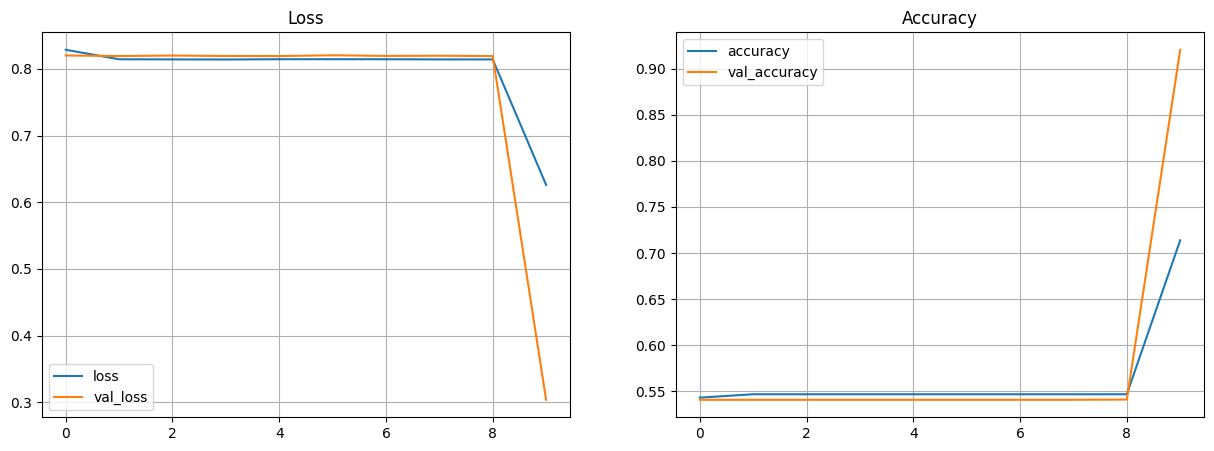

In [21]:
# Plots metrics over training history
def plot_metrics(metrics):
    _, ax = plt.subplots(1, 2, figsize=(15, 5))
    metrics[['loss', 'val_loss']].plot(ax=ax[0], title='Loss', grid=True)
    metrics[['accuracy', 'val_accuracy']].plot(ax=ax[1], title='Accuracy', grid=True) 

plot_metrics(df)

# Below is the model with the original labels (6 labels)

In [27]:
df = pd.DataFrame(np.load('logs/history_15_20240129-19_45.npy', allow_pickle=True).item())


df.sort_values(by=['accuracy'], ascending=False)


,loss,accuracy,val_loss,val_accuracy
14,0.179618,0.966083,0.431081,0.89725
13,0.238534,0.957500,0.451158,0.89625
12,0.274731,0.936750,0.517296,0.87675
11,0.325573,0.888583,0.499091,0.85500
10,0.382877,0.866250,0.535183,0.81725
9,0.462176,0.842833,0.565011,0.81750
8,0.592431,0.755667,0.637585,0.74500
7,0.662052,0.734083,0.754973,0.70675
6,0.684385,0.732500,0.796932,0.70900
5,0.711217,0.728000,0.817666,0.70250


Seems like i am getting a pretty good result with 6 labels aswell. I will run predict and see how they perform aswell! Note that i will just duplicate the code below very ugly to just match the requirments...

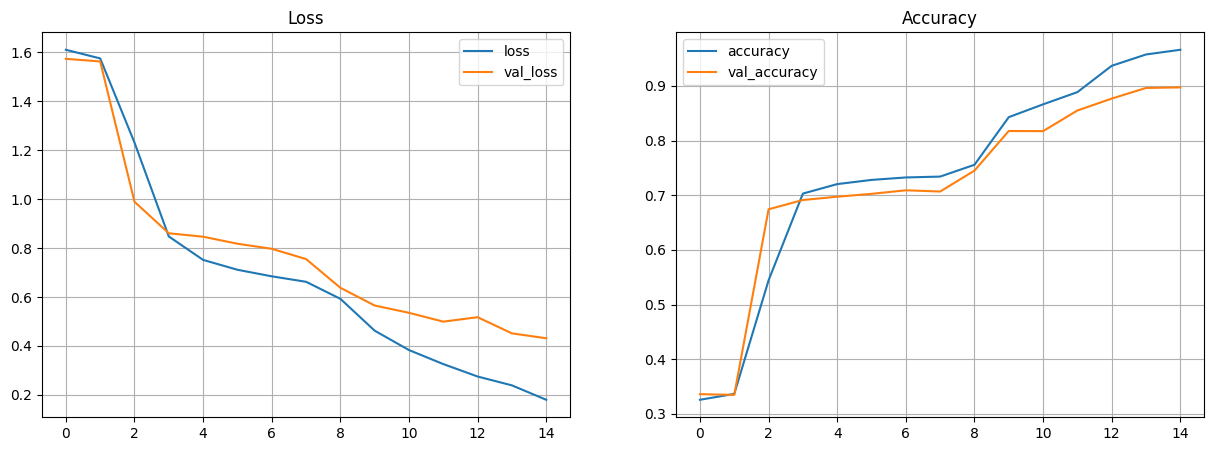

In [28]:
plot_metrics(df)

Here you can see the curve aswell 

In [ ]:
df = pd.DataFrame(np.load('logs/history_26_20240115-122953.npy', allow_pickle=True).item())


df.sort_values(by=['accuracy'], ascending=False)

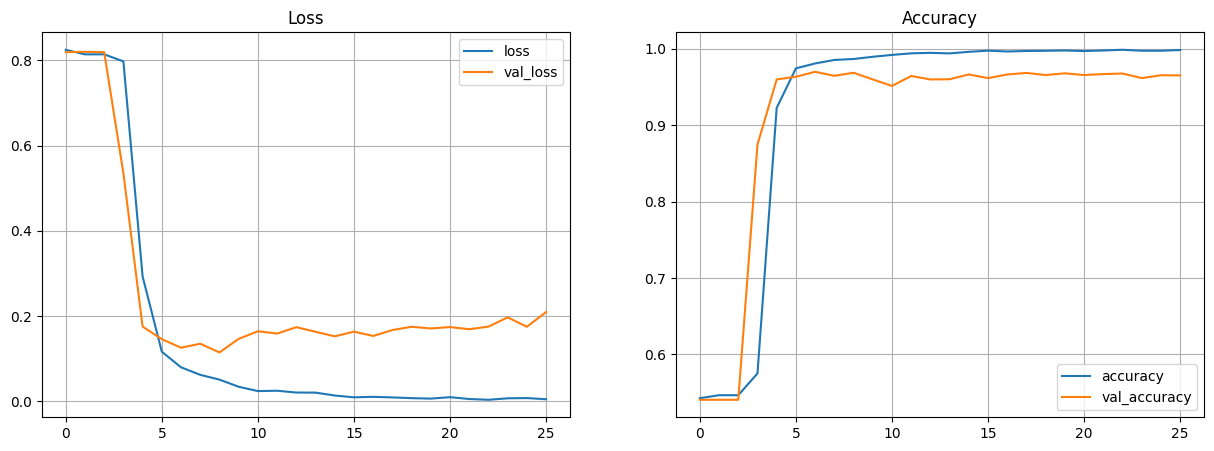

In [ ]:
plot_metrics(df)

This is can work as a sanity check also since it has overtfitted because of the training loss decreasing while val_loss staying the same or increasing

In [ ]:
df = pd.DataFrame(np.load('logs/history_15_20240115-12_48.npy', allow_pickle=True).item())


df.sort_values(by=['accuracy'], ascending=False)

,loss,accuracy,val_loss,val_accuracy
14,0.019578,0.995333,0.140160,0.96500
12,0.025936,0.993167,0.227035,0.94900
13,0.025207,0.993167,0.144806,0.96475
11,0.034211,0.990583,0.140448,0.96150
9,0.038187,0.990083,0.147322,0.96275
10,0.037667,0.989583,0.151741,0.96125
8,0.045291,0.988000,0.171560,0.95625
7,0.047459,0.987083,0.139692,0.96250
6,0.058227,0.983833,0.136907,0.96525
5,0.075883,0.982083,0.123074,0.96575


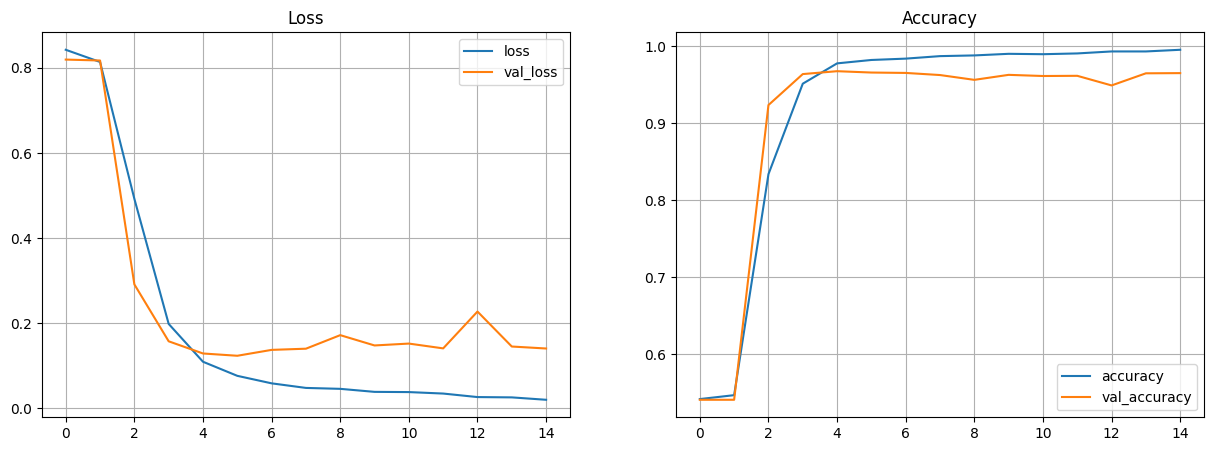

In [ ]:
plot_metrics(df) 

Changed the learning rate to lower value. I made my layers simpler by removing a Dense layer in the NN network. Epoch 4-5 is the best since after that it starts to show tendencys on overfitting due to val_loss staying as is while loss is decreasing. My callback saved the weights for epoch 6 because the val_loss didn't improve after that. So it is perhaps a little bit overfitted because i would have rather saved the weights at 4-5. But 6 will do. 98% accuracy is good. 

# Eval

In [29]:
score = model.evaluate(X_test, y_test, batch_size=32)

print()
print('Accuracy:', score[1])
print('Loss:', score[0])

125/125 [==============================] - 1s 10ms/step - loss: 0.4611 - accuracy: 0.8915

Accuracy: 0.8914999961853027
Loss: 0.4611002802848816


The accuracy for the test data is a little bit lower than train accuracy which is to be expected as completly new data is more challenging.

# Predict

In [30]:
from tensorflow.keras.models import load_model
import time



model_path = 'model/model_20240129-19_45_15.keras'  # This is the one with 6 labels
model = load_model(model_path)


    #df['label'] = df['label'].replace({'anger': 0, 'sadness': 1, 'fear': 2, 'surprise': 3, 'joy': 4, 'love': 5})



def predict(model, text, word_to_id, max_length=35):
    """
    Predict the sentiment of a given text using a pre-trained model.
    
    """

    start_at = time.time()

    # sentiment labels
    sentiment_labels = ['anger', 'sadness', 'fear', 'surprise', 'joy', 'love']

    # Preprocess the text
    text = text.lower()
    text = re.sub(f'[{string.punctuation}]', '', text)
    text = nltk.word_tokenize(text)
    text_indices = [word_to_id.get(word, 0) for word in text]

    if len(text_indices) < max_length: 
        text_indices += [0] * (max_length - len(text_indices)) # pad

    text_array = np.array([text_indices]) # convert to np array list

    # predic
    prediction = model.predict(text_array)
    prediction = np.argmax(prediction, axis=1)


    return {'Sentiment': (sentiment_labels[prediction[0]],),
       'elapsed_time': time.time()-start_at}  



text = "happy happy happy happy"
print(predict(model, text, word_to_id))

text = 'i like sonam deepika and genelia who i feel are very talented and beautiful	'
print(predict(model, text, word_to_id))

text = 'i dont like this '
print(predict(model, text, word_to_id))

text = 'THIS is so shit'
print(predict(model, text, word_to_id))




text = 'this is both good and bad'
print(f' Commented this --> {predict(model, text, word_to_id)}')

get_separator()

text = 'Your appointment is next Wednesday.'
print(predict(model, text, word_to_id))

text = 'it was a funny way they way the explained'
print(predict(model, text, word_to_id))

text = 'it was a funny way '
print(predict(model, text, word_to_id))

get_separator()




text = 'i am having a blast'
print(predict(model, text, word_to_id))

text = 'good this is '
print(predict(model, text, word_to_id))

text = 'this is good'
print(predict(model, text, word_to_id)) #?????????????????????



1/1 [==============================] - 0s 489ms/step
{'Sentiment': ('joy',), 'elapsed_time': 0.540762186050415}
1/1 [==============================] - 0s 31ms/step
{'Sentiment': ('joy',), 'elapsed_time': 0.07907581329345703}
1/1 [==============================] - 0s 26ms/step
{'Sentiment': ('love',), 'elapsed_time': 0.07621121406555176}
1/1 [==============================] - 0s 26ms/step
{'Sentiment': ('love',), 'elapsed_time': 0.07409381866455078}
1/1 [==============================] - 0s 25ms/step
 Commented this --> {'Sentiment': ('love',), 'elapsed_time': 0.07126617431640625}
1/1 [==============================] - 0s 27ms/step
{'Sentiment': ('love',), 'elapsed_time': 0.07460308074951172}
1/1 [==============================] - 0s 26ms/step
{'Sentiment': ('love',), 'elapsed_time': 0.07587599754333496}
1/1 [==============================] - 0s 28ms/step
{'Sentiment': ('love',), 'elapsed_time': 0.07218313217163086}
1/1 [==============================] - 0s 25ms/step
{'Sentiment': ('lov

Okay so it predicts correctly on some of the sentiments, but it's actually not that good because it doesn't understand the context. 

## --------------------------------------


- ** (Comment) 
When i tried to make it predict a neutral label it didn't work and predicted it as negative instead. Perhaps because i have a too small portion of the dataset that was neutral and also that the data was a bit biased towards being negative from the start with more people being negative

- Also the appointment is next wednesday is neither negative or positive but my model is labeling it as negative.

- Conclusion is that even though i have a high result on the model it's not really that good in reality, because it doesn't really understand the relationships between context and words and if its a statement etc, only a very very crude understanding that isn't correct always either. The obvious case is to work more with the data which i have spent the least time with developing and since the dataset was skewed from the start.

# Traditional vs Generative AI (Key differences)

- Traditional AI is:
    - more rule based decision making
    - pattern recognition
    - needs a clear input or output
    - solves specific tasks with predefined rules
    - examples where traditional ai is employed is for instance chess ai
    - often employs supervised learning

- Generative AI
    - ChatGpt
    - Based more on deep learning architechture
    - can create unique outputs
    - can create new data trying to often resemble human-created content.
    - learns patterns and structures by underlying patterns and relationships within the data
    - can work both supervised/unsupervised learning
    